# TASK 2.2: Tracking with a Kalman Filter

In [26]:
from __future__ import print_function
from skimage import io
from tqdm import tqdm
from sort import *
from IPython import display as dp
import matplotlib.pyplot as plt  
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import pickle as pkl
import os
import time
import cv2
plt.style.use("default")
%matplotlib inline

First we load all the data

In [27]:
# Detection to DataFrame
def get_detection_dataframe(detections):
    bboxes = []
    bsizes = []
    bdetections = []
    tracks = list(range(0, len(detections)))
    
    colours = []
    for i in range(len(detections)):
        colours.append(tuple(np.random.choice(range(256), size=3).astype('int')))
    
    for detection in detections:
        bbox = np.array(detection.getBBox()).astype('int')
        bboxes.append(bbox)

        bsize = int(detection.areaOfRec())
        bsizes.append(bsize)

        bdetections.append(detection)

    detec = {
        'track': tracks,
        'detection': bdetections,
        'bbox': bboxes,
        'size': bsizes,
        'colour': colours,
    }
    detections_pd = pd.DataFrame(detec)
    detections_pd = detections_pd.sort_values(by=['size'], ascending=False)
    detections_pd = detections_pd.reset_index(drop=True)
    
    return detections_pd

In [31]:
# Load paths
file_path = 'retinanet_101_detections_trained_2.pkl'
data_path = '../datasets/AICity_data/train/S03/c010/'
video_path = '../datasets/AICity_data/train/S03/c010/vdo.avi'

# Load detections
with open(file_path , 'rb') as f:
    all_detections = pkl.load(f)

print(type(all_detections))
get_detection_dataframe(all_detections[str(0)]).sort_values("track")

<class 'dict'>


,track,detection,bbox,size,colour
2,0,"Frame 0, TL [1176.062744140625,82.149505615234...","[1176, 82, 1253, 173]",7036,"(26, 135, 182)"
3,1,"Frame 0, TL [574.113037109375,73.5157394409179...","[574, 73, 661, 144]",6257,"(82, 186, 75)"
0,2,"Frame 0, TL [1284.9754638671875,364.3419494628...","[1284, 364, 1516, 547]",42316,"(57, 186, 204)"
4,3,"Frame 0, TL [931.6669921875,78.27645874023438]...","[931, 78, 1012, 145]",5487,"(13, 200, 232)"
1,4,"Frame 0, TL [558.3445434570312,94.385581970214...","[558, 94, 664, 169]",7909,"(18, 145, 170)"
5,5,"Frame 0, TL [913.7059936523438,93.219367980957...","[913, 93, 972, 144]",3006,"(44, 226, 203)"
7,6,"Frame 0, TL [878.1730346679688,107.30208587646...","[878, 107, 927, 145]",1893,"(87, 70, 206)"
6,7,"Frame 0, TL [894.3372802734375,95.207916259765...","[894, 95, 945, 143]",2479,"(46, 54, 178)"


## Sort Kalman Filter Model for tracking

We use the Sort Kalman filter and save the generated bboxes

In [38]:
# Load video frames
vidcap = cv2.VideoCapture(video_path)
num_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
results = {}

mot_tracker = Sort(max_age=1, min_hits=3, iou_threshold=0.3)# Sort Kalman tracker with default values

# Iterate Frames
for frame in tqdm(range(num_frames), desc = "Tracking objects each frame..."):
    dets = []

    _, im = vidcap.read() # Read frame
    detections = get_detection_dataframe(all_detections[str(frame)]).sort_values("track") # Load detections

    for (track_id, det, bbox, size, colour) in detections.itertuples(index=False): # Iter All Detections
        dets.append(np.array(bbox))


    trackers = mot_tracker.update(np.array(dets)) # Update tracker with current detections


    for d in trackers: # Store new bboxes
        d = d.astype(np.int32)
        if frame not in results:
            results[frame] = {d[4] % 47: {"bbox": [d[0], d[1], d[2], d[3]]}}
        else:
            results[frame][d[4] % 47] = {"bbox": [d[0], d[1], d[2], d[3]]}

            
# Save Results to Disk
pkl.dump(results, open("sort_bbox.pkl", "wb"))

Tracking objects each frame...: 100%|██████████| 2141/2141 [00:28<00:00, 74.71it/s]


In [39]:
# Pkl to pd.DataFrame
colours = np.random.rand(47, 3) #Generate Random Colors
old_pkl = pkl.load(open("sort_bbox.pkl", "rb"))
new_pkl = []
df = None

for frame in old_pkl.keys():
    new_data = {"frame": [],"track": [], "bbox": [], "colour": [], "size": []}
    old_data = old_pkl[frame]
    
    for track_id in old_data.keys():
        new_data["track"].append(track_id)
        bbox = old_data[track_id]["bbox"]
        new_data["bbox"].append(bbox)
        new_data["frame"].append("Frame {}".format(frame))
        new_data["colour"].append(np.round(colours[track_id]*255).astype(np.uint8))
        new_data["size"].append(int(np.abs(bbox[0] - bbox[2]) * np.abs(bbox[1] - bbox[3])))
    
    df = pd.DataFrame.from_dict(new_data).sort_values(by="track")

    new_pkl.append(df)

pkl.dump(new_pkl, open("kalman_tracking.pkl", "wb"))

In [40]:
new_pkl = pkl.load(open("kalman_tracking.pkl", "rb"))
new_pkl[0]

,frame,track,bbox,colour,size
7,Frame 0,28,"[1176, 82, 1253, 173]","[240, 200, 202]",7007
6,Frame 0,29,"[574, 73, 661, 144]","[52, 133, 251]",6177
5,Frame 0,30,"[1284, 364, 1516, 547]","[161, 60, 129]",42456
4,Frame 0,31,"[931, 78, 1012, 145]","[254, 245, 7]",5427
3,Frame 0,32,"[558, 94, 664, 169]","[147, 86, 160]",7950
2,Frame 0,33,"[913, 93, 972, 144]","[188, 237, 146]",3009
1,Frame 0,34,"[878, 107, 927, 145]","[233, 72, 187]",1862
0,Frame 0,35,"[894, 95, 945, 143]","[77, 187, 203]",2448


Now let's plot the results

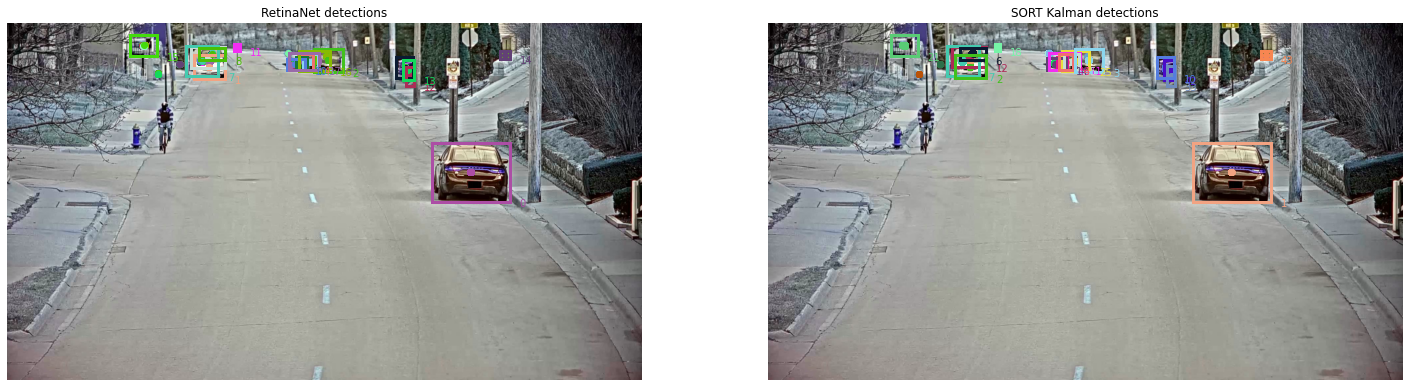

In [ ]:
# Load Data
colours = np.random.rand(47, 3) #Generate Random Colors
vidcap = cv2.VideoCapture(video_path)
num_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
results_kalman = pkl.load(open("sort_bbox.pkl", "rb"))

# Generate Plot
plt.ion()
fig, ax = plt.subplots(1, 2,figsize=(25,25))

# Store centroids
centers_kalman = []
centers_retina = []
frame = 0

# Iterate Frame
for rframe in range(num_frames//2):
    for _ in range(2):
        _, im = vidcap.read() # Read frame
        frame += 1
    detections = get_detection_dataframe(all_detections[str(frame)]).sort_values("track") # Load detections
    
    # Plot Images
    ax[0].imshow(im)
    ax[0].axis('off')
    ax[0].set_title('RetinaNet detections')
    ax[1].imshow(im)
    ax[1].axis('off')
    ax[1].set_title('SORT Kalman detections')
    
    # Iterate Both detections
    for (track_id, det, bbox, size, colour) in detections.itertuples(index=False):
        # RetinaNet Coords, bbox, centroids and id
        coords_retina = (bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1] # coords
        center_retina = ((bbox[0]+bbox[2])/2, (bbox[1]+bbox[3])/2 , colours[track_id], track_id)# centroid
        centers_retina.append(center_retina)
        # Plot BBox and ID
        ax[0].add_patch(plt.Rectangle(*coords_retina,fill=False,edgecolor=colours[track_id],lw=3))
        ax[0].text(bbox[2]+30, bbox[3]+15, str(track_id), color=colours[track_id])

        # Plot tracking line
        if len(centers_retina) > 1:
            for (x, y, c, t) in centers_retina:
                ax[0].scatter([x],[y],marker="o",color=c)
        else:
            x, y, c, t = centers_retina[0][0], centers_retina[0][1], centers_retina[0][2],centers_retina[0][3]
            ax[0].scatter([x],[y],marker="o",color=c)
            
    for track_id in results_kalman[frame].keys():
        
        # Kalman Coords, bbox, centroids and id
        kalman_bbox = results_kalman[frame][track_id]["bbox"]
        coords_kalman = (kalman_bbox[0], kalman_bbox[1]), kalman_bbox[2]-kalman_bbox[0], kalman_bbox[3]-kalman_bbox[1]
        center_kalman = ((kalman_bbox[0]+kalman_bbox[2])/2, (kalman_bbox[1]+kalman_bbox[3])/2, colours[track_id], track_id)
        centers_kalman.append(center_kalman)
        # Plot BBox and ID
        ax[1].add_patch(plt.Rectangle(*coords_kalman,fill=False,edgecolor=colours[track_id],lw=3))
        ax[1].text(kalman_bbox[2]+30, kalman_bbox[3]+15, str(track_id), color=colours[track_id])


        # Plot tracking line
        if len(centers_kalman) > 1:
            for (x, y, c, t) in centers_kalman:
                ax[1].scatter([x],[y],marker="o",color=c)

        else:
            x, y, c, t = centers_kalman[0][0], centers_kalman[0][1], centers_kalman[0][2],centers_kalman[0][3]
            ax[1].scatter([x],[y],marker="o",color=c)


    
    # Save Frame
    plt.savefig('kalman_filter_frames/frame{}.png'.format(frame))
    # Clear figure for animation effect
    dp.clear_output(wait=True)
    dp.display(plt.gcf())
    time.sleep(0.000001)
    ax[0].cla()
    ax[1].cla()